In [1]:


import pandas as pd
import numpy as np
import gzip
import os
from datetime import datetime
from datetime import timedelta 
import pandas as pd
import calendar
import numpy as np
import glob
import sys
import datetime 

import re
import os
import quantstats as qs
import time

import matplotlib.pyplot as plt

import nest_asyncio # install this package to avoid running in loop

import urllib

import pandas_market_calendars as mcal

import pandas_ta as pta

qs.extend_pandas()

# import dask.dataframe as dd
# from dask.distributed import Client
from concurrent.futures import ThreadPoolExecutor

import talib
from Process_trade_log_equity import * 

import sys
#sys.path.append(r'C:\Users\Administrator\Desktop\Indian_backtester_python')

from strategy_functions import *

from fetchHistData import *
import sys
#sys.path.append(r"C:\Users\Administrator\Desktop\Repos\Trade_log_equity")
#from Process_trade_log_equity import *   # Import the module

import warnings

# Suppress all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


#--- Input file with 15 min data

ifol = r"C:\Users\Administrator\Downloads\DATA (1)\DATA\NF_200\NF_200_Equity_parquet_30min"

stock_data = r"C:\Users\Administrator\Downloads\DATA (1)\DATA\NF_200\NF_200_Equity_parquet_30min"


strategy_name = "Aakash_Equity_1_CF_R1_test_long_6"

base_folder = r"C:\Users\Administrator\Documents\ES's and trade_stats_figures"

# Create a folder for the strategy_name if it doesn't exist
strategy_folder = os.path.join(base_folder, strategy_name)
if not os.path.exists(strategy_folder):
    os.makedirs(strategy_folder)

# Create the full path to the output file
output_all_trades_file = os.path.join(strategy_folder, f"All_trades_{strategy_name}.csv")
trade_html_file = os.path.join(strategy_folder, f"Trade_stats_{strategy_name}.html")    




#=== location to store the trade dataframe for debug

base_folder_df = r"C:\Users\Administrator\Documents\strategy_logs"
df_folder = os.path.join(base_folder_df, strategy_name)
if not os.path.exists(df_folder):
    os.makedirs(df_folder)

#----- symbol_wise_trades 

trades_folder = r"C:\Users\Administrator\Documents\symbol_wise_trades"
trades_strategy_folder = os.path.join(trades_folder, strategy_name)
if not os.path.exists(trades_strategy_folder):
    print("\n Making folder for symbol wise trades of strategy" , trades_strategy_folder)
    os.makedirs(trades_strategy_folder)






C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Index(['entry_time', 'Symbol', 'Side', 'entry_price', 'exit_time',
       'exit_price', 'order'],
      dtype='object')


In [2]:

def ATR_multi_timeframe(df , timeframe='1D' , length=3 , opencol = 'Open'  , highcol='High' , lowcol = 'Low' , closecol='Close' , volcol='Volume'  ,  mamode='RMA'  , talib=True  , percent=False):


    import pandas as pd
    import pandas_ta as pta

    # Assuming 'data' is your DataFrame with daily data
    # Replace 'YourHighColumn', 'YourLowColumn', and 'YourCloseColumn' with actual column names from your data
    daily_data = resample_data(df , highcol = highcol , lowcol = lowcol , closecol = closecol ,opencol = opencol  , volcol = volcol , timeframe = timeframe)
    #print(daily_data)
    
    daily_data.dropna(how='all' , inplace=True)
    
    # Calculate daily ATR for the series
    
    last_3_days_atr = pta.atr(daily_data[highcol], daily_data[lowcol], daily_data[closecol], length=length ,  mamode=mamode  , talib=talib  , percent=percent)
    #print(last_3_days_atr)
    
#     rolling_mean = last_3_days_atr.rolling(window=40 , min_periods=3).mean()
#     rolling_std = last_3_days_atr.rolling(window=40, min_periods=3).std()

#     # Calculate the rolling Z-Score and handle division by zero
#     rolling_z_score = (last_3_days_atr - rolling_mean) / rolling_std

#     # Replace infinities with NaNs if any
#     rolling_z_score.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    
    
    #--- Shift by one to remove future bias
    last_3_days_atr = last_3_days_atr.shift(1)
    #print("\n After shift the last 3 days ATR" ,last_3_days_atr )
    
    last_3_days_atr = last_3_days_atr.reindex(df.index, method='ffill')
    #rolling_z_score = rolling_z_score.reindex(df.index, method='ffill')
 
    return last_3_days_atr




def calculate_rolling_beta(df, window , stock_col = 'Close' , index_col = 'Close_index'):
    # Calculate daily returns
    
    
    
    df_copy = df.copy(deep=True)
    
    df['Stock_Returns'] = df[stock_col].pct_change()
    df['Index_Returns'] = df[index_col].pct_change()
    
    # Calculate rolling covariance of stock returns with index returns
    rolling_cov = df['Stock_Returns'].rolling(window=window).cov(df['Index_Returns'])
    
    # Calculate rolling variance of index returns
    rolling_var = df['Index_Returns'].rolling(window=window).var()
    
    # Rolling beta is the rolling covariance divided by the rolling variance
    rolling_beta = rolling_cov / rolling_var
    
    return rolling_beta



def calculate_rolling_beta_from_intraday(df, window , stock_col = 'Close' , index_col = 'indClose'):
    # Calculate daily returns
    
    
    
    df_copy = df.copy(deep=True)
    
    
    dfd = resample_data(df , highcol = 'High' , lowcol = 'Low' , closecol = 'Close' ,opencol = 'Open'  , volcol = 'Volume' , timeframe = '1D')
    #df[closecol].resample(timeframe, origin='start').last().dropna()
    print("\n Initial dataframe is " , df)
    dfd['index_dclose'] = df[index_col].resample('D', origin='start').last().dropna()
    
    #print(dfd)
    
    
    dfd['Stock_Returns'] = dfd[stock_col].pct_change()
    dfd['Index_Returns'] = dfd['index_dclose'].pct_change()
    
    # Calculate rolling covariance of stock returns with index returns
    rolling_cov = dfd['Stock_Returns'].rolling(window=window).cov(dfd['Index_Returns'])
    
    # Calculate rolling variance of index returns
    rolling_var = dfd['Index_Returns'].rolling(window=window).var()
    
    # Rolling beta is the rolling covariance divided by the rolling variance
    rolling_beta = rolling_cov / rolling_var
    
    rolling_beta = rolling_beta.reindex(df.index, method='ffill')
    
    return rolling_beta


#===========================================================

def calculate_rolling_beta(df, window , stock_col = 'Close' , index_col = 'Close_index'):
    
    # Calculate daily returns
    
    #--- but u need the daily 
    
    
    
    df_copy = df.copy(deep=True)
    
    df['Stock_Returns'] = df[stock_col].pct_change()
    df['Index_Returns'] = df[index_col].pct_change()
    
    # Calculate rolling covariance of stock returns with index returns
    rolling_cov = df['Stock_Returns'].rolling(window=window).cov(df['Index_Returns'])
    
    # Calculate rolling variance of index returns
    rolling_var = df['Index_Returns'].rolling(window=window).var()
    
    # Rolling beta is the rolling covariance divided by the rolling variance
    rolling_beta = rolling_cov / rolling_var
    
    
    
    
    return rolling_beta
    




In [3]:


#=== Code to group the symbol dataframe by positions.. ie each group is a trade
#--- helps in finding all the trades( entry  , exit)


def create_tradelog(df , Symbol=None ):
    
    
    """
    This function groups the positions into a dataframe for each symbol and returns the trade_log.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame with Close and position , order and bar-by-bar returns
                             

    Returns:
    pandas.dataframe: A dataframe with each trade in format 
                      : Symbol	Side	EntryPrice	Stop Loss	Time of Entry	Time of Exit	Exit Reason	inposition	Exit Price

    """
    
    
    
     # Check if DataFrame is empty
    if df.empty:
        print("DataFrame is empty. No data to process.")
        return pd.DataFrame()  # Return an empty DataFrame

    
    df['position_change'] = df[f'{symbol}_position'].diff()
    print("\nSymbol passed to trade log: " , Symbol , "\n\n")
    
    
        # Construct column names dynamically
    columns = [
        f'{symbol}bar_count', f'{symbol}_position',  'position_change' , f'{symbol}_ret', f'{symbol}_Close' , f'{symbol}_order']

    # Now filter the DataFrame to include only the columns for this symbol
    df = df[columns]

    
    
    # Assuming 'df' is your DataFrame with the columns 'A_Close', 'A_position', and 'A_ret'.

    # Detect changes in 'A_position'
    if Symbol+'_position' in df.columns:
        df['position_change'] = df[Symbol+'_position'].diff()
    
    else:
        print("\n Position column ( 1 , 0 , -1) missing in dataframe please check")
        
        
    # Assign a group number to each sequence of 1's
    df['group'] = (df['position_change'] == 1).cumsum()

    # Filter out the rows where 'A_position' is not 1
    df_positions_1 = df[df[Symbol+'_position'] == 1]
    
    if df_positions_1.empty:
        print(f"No trade entries found for symbol {Symbol}.")
        return pd.DataFrame()
    
    # Now you can group by the 'group' column
    grouped = df_positions_1.groupby('group')

    # If you want to see the groups

    # Initialize a list to store your results
    trade_returns = []

    for name, group in grouped:
        #print(f"Group {name}:")
        #print(group)

        start_price = group[Symbol+'_Close'].iloc[0]
        end_price = group[Symbol+'_Close'].iloc[-1]
        trade_return = end_price / start_price - 1
        start_time = group.index[0]
        end_time = group.index[-1]
        exit_order = group[Symbol+'_order'].iloc[-1]
        # Assume the position is consistent within the group and take the first one
        position = group[Symbol+'_position'].iloc[0]
        side = 'long' if position == 1 else 'Short' if position == -1 else 'flat'

        
        
        trade_returns.append({
            'Symbol': Symbol,
            'Side': side,
            'entry_time': start_time,
            'entry_price': start_price,
            'exit_time': end_time, 
            'exit_price': end_price,
            'order' : exit_order
        })

        
    # Convert the list of dictionaries to a DataFrame
    trade_returns_df = pd.DataFrame(trade_returns)
    #print("\nThe trade log is" , trade_returns_df)
    if not trade_returns_df.empty:
        trade_returns_df.set_index('entry_time', inplace=True)
    return trade_returns_df
    

In [4]:
import pandas as pd


def create_tradelog2(df, symbol):
    
    print("\nCreating trade log for", symbol)
    
    if df.empty:
        print("DataFrame is empty. No data to process.")
        return pd.DataFrame()
    df['position_change'] = df[f'{symbol}_position'].diff()
    
        # Construct column names dynamically
    columns = [
        f'{symbol}bar_count', f'{symbol}_position',  'position_change' , f'{symbol}_ret', f'{symbol}_Close' , f'{symbol}_order']

    # Now filter the DataFrame to include only the columns for this symbol
    df = df[columns]

    
    
    # Assuming 'bar_count_col' and other columns are defined as per your data
    bar_count_col = f'{symbol}bar_count'

    # Check if the essential column exists in the DataFrame
    if bar_count_col not in df.columns:
        print(f"Missing essential column: {bar_count_col}")
        return pd.DataFrame()
    
    # Identifying the end of a trade
    df['trade_end'] = (df[bar_count_col].shift(-1) < df[bar_count_col]) | (df[bar_count_col].shift(-1) == 0) | df[bar_count_col].eq(0)

    # Creating 'trade_start' to identify the start of a trade
    df['trade_start'] = df['trade_end'].shift(1).fillna(False) | df[bar_count_col].eq(1)
    df['trade_start'] = df['trade_start'].astype(int)

    # Generating 'trade_id' for each trade
    df['trade_id'] = df['trade_start'].cumsum()

    # Filtering out rows not part of any trade (i.e., before any trade has started)
    df = df[df['trade_id'] > 0]
    
    # Processing each trade to gather trade details
    trades_info = []
    for trade_id, trade_group in df.groupby('trade_id'):
        if trade_group.empty or trade_group[bar_count_col].max() == 0:
            continue  # Skip empty trades or trades without bar counts
        
        #print("\n Individual trade found as " , trade_group)
        
        #print("\n Exit price: " , trade_group.iloc[-1][f'{symbol}_Close'])
        positionn = trade_group[f'{symbol}_position'].iloc[0]
        side = 'long' if positionn == 1 else 'Short' if positionn == -1 else 'flat'
        
        trade_details = {
            'Symbol': symbol,
            'Side': side,
            'Trade ID': trade_id,
            'Start Time': trade_group.index[0],
            'End Time': trade_group.index[-1],
            'Entry Price': trade_group.iloc[0][f'{symbol}_Close'],  # Assuming 'Close' is the close price column
            'Exit Price': trade_group.iloc[-1][f'{symbol}_Close'],  # Modify as per your DataFrame's column names
            # Include other details as needed
        }
        trades_info.append(trade_details)
    
    # Converting the trades information into a DataFrame
    trade_summary_df = pd.DataFrame(trades_info)
    return trade_summary_df

# Replace 'your_symbol' and 'Close' with actual column names as per your DataFrame
# Ensure your DataFrame 'df' is indexed appropriately (e.g., datetime index) and contains the necessary columns


In [5]:
#"C:\Users\Administrator\Downloads\DATA (1)\DATA\index\NIFTY50\NIFTY50.csv"



index_data_loc = r"C:\Users\Administrator\Downloads\DATA (1)\DATA\index\NIFTY50\NIFTY50.csv"

def process_index(indexpath , timeframe='30Min'):
    
    

    index_df = pd.read_csv(indexpath)
    
    if 'datetime' in index_df.columns:
    
        index_df.datetime = pd.to_datetime(index_df.datetime , format="%d-%m-%Y %H:%M")
        index_df.set_index('datetime' , inplace=True)

    #print(index_df)   

             
    index_df = index_df[(index_df.index.dayofweek<5)]
     
    ind_df = resample_data(index_df , highcol = 'High' , lowcol = 'Low' , closecol = 'Close' ,opencol = 'Open'  , volcol = 'Volume' , timeframe = '30min')


    #print(ind_df) 
    ind_df['ind20DMA'] = daily_moving_average(df=ind_df, timeframe='D' , column='High', periods=10, agg_func='last')
        
    ind_df['indtodayo'] = ind_df.Open.groupby(ind_df.index.date).first().reindex(ind_df.index.date).values
    ind_df['indprevdayc'] = ind_df.Close.groupby(ind_df.index.date).last().shift().reindex(ind_df.index.date).values
    ind_df['indprevdayh'] = ind_df.High.groupby(ind_df.index.date).max().shift().reindex(ind_df.index.date).values
    ind_df['indprevdayo'] = ind_df.Open.groupby(ind_df.index.date).first().shift().reindex(ind_df.index.date).values
                                                      
    ind_df['near_Exp'] = get_prev_exp(ind_df.index , symbol='NIFTY')
    
    ind_df['ind_todayh'] = intraday_high(df=ind_df ,high_col= 'High' ,agg_func= 'max')
    ind_df['ind_todayl'] = intraday_low(df=ind_df ,low_col= 'Low' , agg_func='min')
            
    ind_df['indexpiry_high'] = expanding_high_since_expiry(ind_df , expiry_series='near_Exp' , column='High')
        
    ind_df['indexpiry_low'] = expanding_low_since_expiry(ind_df , expiry_series='near_Exp' , column='Low')
            
    ind_df = ind_df[(ind_df.index.year>=2019) & (ind_df.index.year<2023)]
        
    #ind_df = ind_df.reindex(combined_df.index, method='ffill')
            
    return ind_df
    



In [6]:
ind_df = process_index(index_data_loc , timeframe='30Min')
ind_df = ind_df.rename(columns={
    'Open': 'indOpen',
    'High': 'indHigh',
    'Low': 'indLow',
    'Close': 'indClose',
    'Volume':'indVolume'
    # Add other column mappings if necessary
})

In [158]:

def rank_base_on_parameter(file_path , index_req=1 , indexdf=ind_df):
    
    fname = os.path.basename(file_path).split('.')[0]
    
    #print("\n Processing ", fname)
    
    df = pd.read_parquet(file_path, engine='fastparquet')
    
    
    if index_req==1:
        

        #===== First reindex the index to df
        indexdf = indexdf.reindex(df.index, method='ffill')

        df = pd.concat([df, indexdf], axis=1)

    
    #print( "\n Before calculation df is ", df)
    
    #beta = calculate_rolling_beta_from_intraday(df , window=40 , stock_col='Close' , index_col= 'indClose' )
    
    df['20DMA'] = daily_moving_average(df , 'D' , 'High' , periods=10 , agg_func='last')
    
    df['prevdayl'] = df.Low.groupby(df.index.date).min().shift().reindex(df.index.date).values
    
    
    #rsiv = rsi_timeframe(df , column='Close' , period=3 , timeframe='1D')
    
    ratiop = df['prevdayl']/df['20DMA']
    
    
    #print(beta)
    
    
    df['rank_param'] = ratiop
    
    
    # Using dictionary comprehension to create a new column names mapping
    columns_mapping = {old_name: f'{fname}_{old_name}' for old_name in df.columns}
    
    df_renamed = df.rename(columns=columns_mapping)
            #print(df_renamed)
    
    #print("\n processed df is " , df_renamed)
    
    if df_renamed.empty:
            return None
    else:
        return df_renamed[f'{fname}_rank_param']
    


In [148]:
def process_symbol(file_path , index=ind_df):
    
    
    fname = os.path.basename(file_path).split('.')[0]
    
    print("\n Processing ", fname)
    
    df = pd.read_parquet(file_path, engine='fastparquet')
    
    #df['first_hr_high'] =  x_min_high(df , 'High' , start='09:30' , end='11:00' )
   # df['cval'] = x_min_cum_vol(df , 'Volume' , start='09:30' , end=rank_time)
    df['x_day_low'] = get_x_day_low(df, n=10 , column='Close')
    df['x_day_high'] = get_x_day_high(df , n=20 , column='High')
    #df['m_low'] = get_x_day_low(df , n=40 , column='Close')
    #df['low_touch'] = np.where(df['Close']<df['x_day_low'].shift() , 1 , 0)
    
    #df[fname+'_ratio'] = df['cval']/df['D_Volume_moving_average']
    #df['bars_since_low'] = bars_since_condition(df , column='low_touch')
        
    df['5drng'] = get_x_day_range(df , n=5, high_col='High' , low_col='Low')
    
    df['20DMA'] = daily_moving_average(df , 'D' , 'High' , periods=3 , agg_func='last')
    
    #df[fname+'_ratio'] = df['cval']/df['D_Volume_moving_average']
        
    df['todayo'] = df.Open.groupby(df.index.date).first().reindex(df.index.date).values
    df['prevdayc'] = df.Close.groupby(df.index.date).last().shift().reindex(df.index.date).values
    df['ratio_co'] = df['Close']/(df[['todayo', 'prevdayc']].max(axis=1))
    df['prevdayl'] = df.Low.groupby(df.index.date).min().shift().reindex(df.index.date).values
    df['prevdayh'] = df.High.groupby(df.index.date).max().shift().reindex(df.index.date).values
    df['prevdayo'] = df.Open.groupby(df.index.date).first().shift().reindex(df.index.date).values
    #df['slope'] = find_slope_and_prediction(df , 'Low' , window=100)[0]
    df['vwap'] = intraday_vwap(df)
    
#     df['ATR'] = ATR(highcol=df['High'] , lowcol=df['Low'] , closecol=df['Close'] , length=7 , percent=False , mamode='WMA')
#     df['ATR_zc'] = z_score_price(df ,  'ATR' , window_size=3)
    df['z_score'] = z_score_price(df , column='High' , window_size=13)
    
    
    #=== Find ATR and z-score of ATR
    df['ATR'] = ATR(highcol=df['High'] , lowcol=df['Low'] , closecol=df['Close'] , length=14 , percent=False , mamode='WMA')
    df['ATR_zc'] = z_score_price(df ,  'ATR' , window_size=50)
    
    #df['last_trough'] = find_trough_multi_tf(df , column='Low' , threshold=0.25, distance=5 , timeframe='1D')
       
    df = pivot_points_classic(df)
    
    df['todayl'] = intraday_low(df=df , low_col='Low' , agg_func='min')
    df['todayh'] = intraday_high(df=df , high_col='High' , agg_func='max')
    df['daily_RSI'] = rsi_timeframe(df ,period=7 , timeframe='1D' )
    df['zc_ROC'] = daily_ROC(df , column='Close' , ROC_period=3 , z_score_period=40)
    df = df[(df.index.year>2019) & (df.index.year<2023)]
    #print("\n" , df.columns)
    
    #====== Index based conditions in any
        
    #===== First reindex the index to df
    index = index.reindex(df.index, method='ffill')
    
    df = pd.concat([df, ind_df], axis=1)
    
    #======= Concat the ranks for each symbol
    
    rank = comb_ranks[f'{fname}_rank_param']
    rank = rank.reindex(df.index , method=None)
    df[f'{fname}_rank_param'] = rank
                      
                    
    #print(  "\n Concated df with index is : " , df)
    
    #df['int_indHigh'] = intraday_high(df=df , high_col='indHigh' , agg_func=)
    
    #=== Long conditions
    # df['ratio_co']>1.005 
    
    condition1 = df.index.time>datetime.time(10 , 15) 
    condition2 = df["indprevdayc"]>df["indprevdayo"]*0.985    #df['Close']>df['x_day_high'] - (0.5*(df['x_day_high']-df['x_day_low']))
    #condition3 = df['Close']<df['R1']
    #condition4 = df['ATR_zc']<=-1
    #condition5 = df['indLow']<df['ind20DMA']
    condition6 = df['prevdayc']>df['prevdayo']*0.98
    #condition7 = df['todayo']>df['m_low']*1.03
    condition8 = df['Close']>df['vwap']*0.995
    condition9 = df['prevdayc']>=df['prevdayo']*0.97
    condition10 = df['daily_RSI']>40
    condition11 = df['todayo']>df['S2']
    condition12 = df['indtodayo']>df['indprevdayc']*0.998  # much better than opposite
    condition13 = df['indClose']>df['ind_todayl']*1.003
    condition14 = df['ATR_zc']<2
    condition15 = df['todayo']<df['prevdayh']*1.05
    condition17 = df['prevdayc']<df['prevdayo']*1.01
    condition18 = df['zc_ROC']<2.5
    condition20 = df['prevdayc']>df['prevdayo']*0.98
    #condition19 = df[f'{fname}_rank_param']<50
    
    #=== price goes below S2 but now above S1
    df['S1_reclaim'] = np.where(((df['todayl']<df['S1']*1.002) & (df['Close']>df['S1'].shift()*1.001))  , 1 , 0)
    condition16 = df['S1_reclaim']>=1
    
    #condition21 = condition20 
            
    
    ofol = df_folder
    ofil = os.path.join(ofol , f'{fname}.csv')
    #print(ofil)
    df.to_csv(ofil)
    
    #df['prevdayc']<df['prevdayo']*1.02 not helping
    #condition14 = df['todayl']>df["last_trough"]*1.01
    #condition14 = df['Close']<df['R2']
    
    #& condition13 is gud
    
    #=== df['Close']>df['first_hr_high'].shift(1) not helping
    #== df['Close']>df['x_day_high'] - (0.25*(df['x_day_high']-df['x_day_low'])) not helping
    #=== 20 dma index MA not helping
    
    # & condition10 trying.. not thta help
    #=== short conditions
    
    # & condition3
    # & condition6
    # & condition14 - df['slope']>0 not helping
    # ATR_zc bad
    # & condition14  & condition10  & condition12  & condition5 & condition7  & condition11
    
    # & condition17
    #& condition15 slight gud
    # & condition14
    df['signal'] = condition1  & condition8 & condition20 & condition2 & condition12 & condition16 & condition13 & condition17 & condition9     
        
    #print("\n Mean of symbol is " , df['Close'].mean())
    
    # Compute the final result and return it as a pandas DataFrame
    return df , fname
    


In [149]:
def process_signal(df, side=1 , intra_Exit=0 , n_day_Exit=2, symbol=None ):
    
    
    #================================================================================================
    if symbol is None:
        raise ValueError("Symbol must be provided")
    
    print("\n Processing signals of", symbol)
    log = []
    bar_counts = [0] * len(df)
    positions = [0]* len(df)
    position = 0
    day_count = 0
    entry_price = 0 
    exit_price = 0 
    ordern = 0 
    orders = [0]*len(df)
    highest_high = 0 
    # Compute date changes using diff()
    #df['date_changed'] = df.index.to_series().diff().dt.days != 0
    
        # Ensure your index is a DateTimeIndex and sorted.
    df['date_changed'] = df.index.to_series().dt.date != df.index.to_series().shift(1).dt.date
    
    #================================================================================================
   
        
    for i in range(len(df)):
        
        row = df.iloc[i]
        current_date = df.index[i].date()
        current_time = df.index[i].time()        
        
                # If in a position, increment the bar count
        if position != 0:
            # Increment bar_count
            bar_counts[i] = bar_counts[i-1] + 1
            # Check if the date has changed and increment day_count if it has
            if row['date_changed']:
                day_count += 1
        else:
            # Reset counts when not in position
            bar_counts[i] = 0
            ordern = 0 
            day_count = 0  # Reset day_count here if that's the intended logic
            entry_price = 0

        
        
        highest_high = row['High'] if position > 0 and row['High'] > highest_high else highest_high if position > 0 else 0
        lowest_along = row['Low'] if position > 0 and row['Low'] < lowest_along else lowest_along if position > 0 else 0
        
        
        if ( df['signal'][i-1]==1 or df['signal'][i]==1 or df['signal'][i-2]==1) and position == 0 and df[f'{symbol}_rank_param'][i]<50 and df['Close'][i]>df['High'][i-1]*1.001 and df['Close'][i]<df['todayo'][i]*1.05 and df['indClose'][i]>df['indtodayo'][i]*0.999 :
            # Determine if it's a long or short entry
            if side > 0:
                position = 1
                entry_price = row['Close']
                ordern = 1
                bar_counts[i]+=1
                print("\n Position taken long at : " , df.index[i] , "-- entry Price - :  " , entry_price , "rank is : "  , df[f'{symbol}_rank_param'][i] )
                log.append((df.index[i], symbol, position , entry_price , ordern))
                #print("\n" , df['5drng'][i])
            else:
                position = -1
                entry_price = row['Close']
                ordern = -1
                bar_counts[i]+=1
                #print("\n Position taken Short at : " , df.index[i] , "-- entry Price - :  " , entry_price)
                log.append((df.index[i], symbol, position , entry_price, ordern))
        
        
        if position == 1 and row['Close'] < min(df['prevdayl'][i]*0.99 ,df['todayl'][i-1]*1.001) and bar_counts[i]>=2:
            
            #print("\n Position Hit stop " , df.index[i] , position , "position at  ", row['Close'] )
            position = 0
            #bar_counts[i] = 0
            exit_price = row['Close']
            ordern = 13
            log.append((df.index[i], symbol, position , row['Close'], ordern))

                
        # End of Day Exit condition based on parameter intra_exit
        
        #print("position " ,position , df['bar_count'][i])
        
        if position != 0 and intra_Exit==1 and df.index[i].time() >= datetime.time(15, 5) and bar_counts[i] > 1:
            
            #print("Hi")
            print("\n Position exit EOD long at" , df.index[i] , position , "position at  ", row['Close'] )
            
            position = 0
            #bar_counts[i] = 0
            exit_price = row['Close']
            ordern = 11 
            log.append((df.index[i], symbol, position , row['Close']))
        
        
        if position != 0 and bar_counts[i]>4 and df['indClose'][i]<df["indOpen"][i-1]*0.985 and df['High'][i]<df['todayh'][i-1]*0.985:
            
            #print("Hi")
            #print("\n Nifty bear exit at: " , df.index[i] ,"Nifty high and highest are:  "  ,df['indHigh'][i] , df['ind_todayh'][i-1]  )
            
            position = 0
            #bar_counts[i] = 0
            exit_price = row['Close']
            ordern = 11 
            log.append((df.index[i], symbol, position , row['Close']))
                       
                
        if position > 0 and day_count>=1 and bar_counts[i]>6 and df['Close'][i]<df['prevdayl'][i]*0.97 and df['Close'][i]<df['Close'][i-1] :
            #print("\n Gap down exit EOD long at" , df.index[i] , position , "position at  ", row['Close'] , "Day_count: " , day_count , "close: " , df['Close'][i] , df['Close'][i-1] )
        
            position = 0
            #bar_counts[i] = 0
            exit_price = row['Close']
            ordern = 13
            log.append((df.index[i], symbol, position , row['Close'], ordern))
        
        if position > 0 and day_count>=2 and bar_counts[i]>3 and df['Close'][i]<df['Low'][i-1]*0.98  :
            #print("\n Large bear bar" , df.index[i]  , "Day_count: " , day_count , "close: " , df['Close'][i] , df['Open'][i] )
        
            position = 0
            #bar_counts[i] = 0
            exit_price = row['Close']
            ordern = 13
            log.append((df.index[i], symbol, position , row['Close'], ordern))
                
        
        if position != 0 and intra_Exit==0 and day_count>=n_day_Exit and bar_counts[i]>1 and df['Close'][i]>df['Close'][i-1]  :
            
            #print("\n Carryforward exit EOD long at" , df.index[i] , position , "position at  ", row['Close'] , "Day_count: " , day_count )
            
            position = 0
            #bar_counts[i] = 0
            exit_price = row['Close']
            ordern = 12
            log.append((df.index[i], symbol, position , row['Close'], ordern))
                
        
        #---- Stop-loss of 3%
        
        if position>0 and df['todayo'][i]<df['x_day_low'][i] and df['Close'][i]<df['Low'][i-1] and day_count>=1 and df.index[i].time()>=datetime.time(10 , 45):
            
            position = 0
            #bar_counts[i] = 0
            exit_price = row['Close']
            ordern = 12
            log.append((df.index[i], symbol, position , row['Close'], ordern))
            
            #print("\nBreakdown opening exit from low:  " , df['x_day_low'][i] ,   " -- open at" , df['todayo'][i])
        
      
        if position>0 and df['High'][i]<df['S1'][i-1] and df['Close'][i]<df['Close'][i-1] and day_count>=2 and df.index[i].time()>=datetime.time(10 , 45):
            
            position = 0
            #bar_counts[i] = 0
            exit_price = row['Close']
            ordern = 13
            log.append((df.index[i], symbol, position , row['Close'], ordern))
            #print("\n SUpport exit")
        
        
        #=== exit of open==high of the day
        
#         if position>0 and day_count>=3  and df['close'][i]>=df['prevdayh'][i]*1.01 and df.index[i].time()>=datetime.time(10 , 00):
            
#             position = 0
#             bar_counts[i] = 0
#             exit_price = row['Close']
#             ordern = 12
#             log.append((df.index[i], symbol, position , row['Close'], ordern))
            
#             print("\n reversal from low:  " ,df['prevdayh'][i],   " -- open at" , df['todayo'][i] , "reversal at: " , df['prevdayc'][i] )
        
        
        
        
        #----- 5drnag exit
        
        if position>0 and row['Close'] > entry_price*(1+(1.5*df['5drng'][i])) and df['Close'][i]>df['Close'][i-1] and bar_counts[i]>10:
            
            #print("\n Range target  " , df.index[i] , "at  ", row['Close'] , " range: " , df['5drng'][i] , "entryprice" , entry_price )
            position = 0
            #bar_counts[i] = 0
            ordern = 15
            log.append((df.index[i], symbol, position , row['Close'], ordern))
        
        
        #print("\n " , df.index[i] , "\n EP: ", entry_price , df['5drng'][i] , bar_counts[i]  )
        
        
         #----- reistance exit
        
        if position >0 and df['Close'][i-1]>df['R2'][i-1]*1.01 and df['Close'][i]<df['R2'][i-1]*1.01 and bar_counts[i]>5 and df.index[i].time() > datetime.time(9, 30):
            
            #print("\n Resistance target  " , df.index[i] , "at  ", row['Close'] , " R2 prev: " , df['R2'][i-1] , "entryprice" , entry_price )
            position = 0
            #bar_counts[i] = 0
            ordern = 16
            log.append((df.index[i], symbol, position , row['Close'], ordern))
        
        
        #--- n-day exit at first bar....
        #print("\n At each bar: " , df.index[i] , "  position is : " , position , " - bar_count " , bar_counts[i])
        
    
        positions[i] = position
        orders[i] = ordern

        
    
    #print("\n Position at last bar is " , positions[-1]   )
    
    df[symbol+'bar_count'] = bar_counts
    df[symbol+'_order'] = orders
    df[symbol+'_position'] = positions
    
    #== these are bar-by-bar returns when you are in position 
    #== we dont take the first bar since we entered at close of this bar
    
    df[symbol+'_ret'] = np.where(df[symbol+'bar_count']>1 ,  df['Close'].pct_change()*side , 0)
    
    
    #=== 
    df[symbol+'_Close'] = df['Close']

    trade_log = create_tradelog2(df , symbol)
    #print(trade_log)

#     if( num_entries!=num_exits):

#         print("\n \n Number of entries and exits dont match"  , "Entries: " , num_entries , "----- Exits" , num_exits  )

    file_path = os.path.join(trades_strategy_folder, f"{symbol}.csv")
    
    print("\n \n The Outputting to trade file " , file_path)
    
    trade_log.to_csv(file_path )
    
        
    
    return df[[symbol+'_Close' , symbol+'_position' ,symbol+'_ret' , symbol+'bar_count', symbol+'_order']] 


In [150]:
def strategy_function(file_path):
    
    df,symbol = process_symbol(file_path , index=ind_df)
        
    cdf  = process_signal(df ,  side=1 , intra_Exit=0 , n_day_Exit=3,  symbol=symbol)    
    
    return cdf
    

In [77]:
cdf = strategy_function(r"C:\Users\Administrator\Downloads\DATA (1)\DATA\NF_200\NF_200_Equity_parquet_30min\AARTIIND.csv.parquet")


 Processing  AARTIIND

 Processing signals of AARTIIND

 Position taken long at :  2020-03-31 14:15:00 -- entry Price - :   377.65 rank is :  84.0

 Position taken long at :  2020-04-23 10:45:00 -- entry Price - :   469.42 rank is :  83.0

 Position taken long at :  2020-04-24 09:45:00 -- entry Price - :   468.15 rank is :  98.0

 Position taken long at :  2020-10-01 12:15:00 -- entry Price - :   512.35 rank is :  99.0

 Position taken long at :  2021-04-16 11:15:00 -- entry Price - :   703.2 rank is :  92.0

 Position taken long at :  2021-08-03 10:45:00 -- entry Price - :   972.4 rank is :  67.0

 Position taken long at :  2021-08-27 13:45:00 -- entry Price - :   921.4 rank is :  83.0

 Position taken long at :  2021-09-17 09:15:00 -- entry Price - :   947.25 rank is :  70.0

 Position taken long at :  2021-10-27 11:45:00 -- entry Price - :   1023.35 rank is :  11.0

 Position taken long at :  2021-11-15 14:15:00 -- entry Price - :   959.45 rank is :  26.0

 Position taken long at :

In [ ]:
df['x_day_low'] = get_x_day_low(df, n=10 , column='Close')
df['x_day_high'] = get_x_day_high(df , n=20 , column='High')
#df['m_low'] = get_x_day_low(df , n=40 , column='Close')
#df['low_touch'] = np.where(df['Close']<df['x_day_low'].shift() , 1 , 0)

#df[fname+'_ratio'] = df['cval']/df['D_Volume_moving_average']
#df['bars_since_low'] = bars_since_condition(df , column='low_touch')
    
df['5drng'] = get_x_day_range(df , n=5, high_col='High' , low_col='Low')


In [ ]:
df[['Close','5drng']].plot()

In [159]:
#---- Process all stocks and rank them based on a paramater
from concurrent.futures import ProcessPoolExecutor


if os.path.exists(stock_data):
    file_paths = glob.glob(stock_data + "/*.parquet")
    
    # Use ProcessPoolExecutor to process multiple files in parallel
    num_cores = os.cpu_count()  # You might want to choose a smaller number depending on your hardware
    with ThreadPoolExecutor(max_workers=num_cores) as executor:
        dataframes = list(executor.map(rank_base_on_parameter, file_paths))

    # Combine df stores the combined rank of all stocks in the file paths
    combined_ranks_df = pd.concat(dataframes, axis=1, join='outer')


In [160]:
comb_ranks = combined_ranks_df.rank(ascending=False ,axis=1)

In [162]:
combined_ranks_df

,AARTIIND_rank_param,ABCAPITAL_rank_param,ABFRL_rank_param,ACC_rank_param,ADANIENT_rank_param,ADANIGREEN_rank_param,ADANIPORTS_rank_param,ADANITRANS_rank_param,AJANTPHARM_rank_param,ALKEM_rank_param,...,ULTRACEMCO_rank_param,UNIONBANK_rank_param,UPL_rank_param,VBL_rank_param,VEDL_rank_param,VOLTAS_rank_param,WHIRLPOOL_rank_param,WIPRO_rank_param,YESBANK_rank_param,ZEEL_rank_param
2019-01-01 09:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 09:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 10:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 10:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 11:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-14 13:15:00,0.98,1.00,0.99,1.01,1.01,0.97,0.99,0.95,0.97,0.99,...,0.99,1.02,0.98,1.01,0.99,0.99,0.98,0.98,1.14,0.98
2022-12-14 13:45:00,0.98,1.00,0.99,1.01,1.01,0.97,0.99,0.95,0.97,0.99,...,0.99,1.02,0.98,1.01,0.99,0.99,0.98,0.98,1.14,0.98
2022-12-14 14:15:00,0.98,1.00,0.99,1.01,1.01,0.97,0.99,0.95,0.97,0.99,...,0.99,1.02,0.98,1.01,0.99,0.99,0.98,0.98,1.14,0.98
2022-12-14 14:45:00,0.98,1.00,0.99,1.01,1.01,0.97,0.99,0.95,0.97,0.99,...,0.99,1.02,0.98,1.01,0.99,0.99,0.98,0.98,1.14,0.98


In [163]:
comb_ranks

,AARTIIND_rank_param,ABCAPITAL_rank_param,ABFRL_rank_param,ACC_rank_param,ADANIENT_rank_param,ADANIGREEN_rank_param,ADANIPORTS_rank_param,ADANITRANS_rank_param,AJANTPHARM_rank_param,ALKEM_rank_param,...,ULTRACEMCO_rank_param,UNIONBANK_rank_param,UPL_rank_param,VBL_rank_param,VEDL_rank_param,VOLTAS_rank_param,WHIRLPOOL_rank_param,WIPRO_rank_param,YESBANK_rank_param,ZEEL_rank_param
2019-01-01 09:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 09:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 10:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 10:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 11:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-14 13:15:00,140.00,50.00,71.00,25.00,32.00,151.00,94.00,190.00,160.00,91.00,...,72.00,12.00,145.00,26.00,81.00,95.00,124.00,146.00,1.00,126.00
2022-12-14 13:45:00,140.00,50.00,71.00,25.00,32.00,151.00,94.00,190.00,160.00,91.00,...,72.00,12.00,145.00,26.00,81.00,95.00,124.00,146.00,1.00,126.00
2022-12-14 14:15:00,140.00,50.00,71.00,25.00,32.00,151.00,94.00,190.00,160.00,91.00,...,72.00,12.00,145.00,26.00,81.00,95.00,124.00,146.00,1.00,126.00
2022-12-14 14:45:00,140.00,50.00,71.00,25.00,32.00,151.00,94.00,190.00,160.00,91.00,...,72.00,12.00,145.00,26.00,81.00,95.00,124.00,146.00,1.00,126.00


In [155]:
from concurrent.futures import ThreadPoolExecutor


if os.path.exists(stock_data):
    file_paths = glob.glob(stock_data + "/*.parquet")

    # Use ProcessPoolExecutor to process multiple files in parallel
    num_cores = os.cpu_count()
    with ThreadPoolExecutor(max_workers=num_cores) as executor:
        dataframes = list(executor.map(strategy_function, file_paths))

# Do something with the results, e.g., concatenate them into a single DataFrame
combined_df = pd.concat(dataframes, axis=1, join='outer')
# Proceed with combined_df as needed


 Processing  AARTIIND

 Processing  ABCAPITAL

 Processing  ABFRL

 Processing  ACC

 Processing signals of ABFRL

 Position taken long at :  2020-02-20 09:15:00 -- entry Price - :   278.95 rank is :  44.0

 Position taken long at :  2020-05-29 09:15:00 -- entry Price - :   120.3 rank is :  41.0

 Position taken long at :  2020-08-17 14:45:00 -- entry Price - :   133.4 rank is :  20.0

 Position taken long at :  2020-10-21 10:45:00 -- entry Price - :   149.05 rank is :  21.0

 Position taken long at :  2020-10-21 14:45:00 -- entry Price - :   151.6 rank is :  21.0

 Position taken long at :  2021-01-13 09:15:00 -- entry Price - :   176.8 rank is :  43.0

 Position taken long at :  2021-06-25 12:15:00 -- entry Price - :   215.65 rank is :  25.0

 Position taken long at :  2022-01-12 12:15:00 -- entry Price - :   306.25 rank is :  38.0

 Position taken long at :  2022-01-17 11:15:00 -- entry Price - :   312.6 rank is :  14.0

 Position taken long at :  2022-03-28 14:45:00 -- entry Price

In [157]:
#----- function to read trade logs and find total profit from all of symbols for them

def read_trade_log(logloc):
    
    
    
    symbol = os.path.splitext(os.path.basename(logloc))[0].lstrip('_')
    print("\n Processing trade log of symbol" , symbol)
    
    
    df = pd.read_csv(logloc)
    if df.empty:
        print("No trades found")
        return None
    else:
        
        print(df.columns)
        df['Entry Price'] = df['Entry Price'].astype('float')
        df['Exit Price'] = df['Exit Price'].astype('float')
        
        # Drop rows where entry_price or exit_price is NaN
        df.dropna(subset=['Entry Price', 'Exit Price'], inplace=True)
        
        
        if 'Side' in df.columns:
            df['returns'] = np.where(df['Side']=='long' , (df['Exit Price']/df['Entry Price'])-1 , (df['Exit Price']-df['Entry Price'])/df['Entry Price'])
        #print(df)
        
        else:
            
            df['returns'] =  (df['Exit Price']/df['Entry Price'])-1
        
        
        net_return = (100000*df["returns"]).cumsum()
        net_return.dropna(inplace=True)
        print( "Symbol return from trade log is : ", net_return.iloc[-1]) 
        return symbol , net_return.iloc[-1]


    
def concatenate_trades(logloc , comb_df , add_slippages=0 , slippage_in_ticks=1 ,min_movement = 0.05):
    
    
    symbol = os.path.splitext(os.path.basename(logloc))[0].lstrip('_')
    print("\n Concqatenating trades of symbol" , symbol)
    
    
    df = pd.read_csv(logloc)
    if df.empty:
        print("No trades found")
        return None
    else:
        
        # Convert entry_price and exit_price to numeric, set errors='coerce' to handle non-numeric
        df['Entry Price'] = pd.to_numeric(df['Entry Price'], errors='coerce')
        df['Exit Price'] = pd.to_numeric(df['Exit Price'], errors='coerce')
  
        
        
        if add_slippages>0:


            df['Entry Price'] = np.where(df['Side']=='long' , (df['Entry Price'] + (slippage_in_ticks*min_movement))  ,  (df['Entry Price'] - (slippage_in_ticks*min_movement)))

            df['Exit Price'] = np.where(df['Side']=='long' , (df['Exit Price'] - (slippage_in_ticks*min_movement))  ,  (df['Exit Price'] + (slippage_in_ticks*min_movement)))

            #print("\n After adding slippages" , df)

               
        # Drop rows where entry_price or exit_price is NaN
        df.dropna(subset=['Entry Price', 'Exit Price'], inplace=True)
        
        comb_df = pd.concat([comb_df , df] , axis=0 , join='outer')
        
        
        return comb_df
    
    
    
    
cdf = pd.DataFrame()
all_trades = pd.DataFrame()

log_path = trades_strategy_folder


print("\ Reading all trade files from folder " , log_path)

if os.path.exists(log_path):
        file_paths = glob.glob(log_path + "/*.csv")
        
        for file in file_paths:
            
            result = read_trade_log(file)
            if result is not None:
                sym, profit = result
            
            cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
            all_trades = concatenate_trades(file , all_trades , add_slippages=0 ,slippage_in_ticks=3 )
        
        all_trades.to_csv(output_all_trades_file)

 
        

#-- this is the win ratio
print(len(all_trades[all_trades['Exit Price']>all_trades['Entry Price']])/len(all_trades))

from Process_trade_log_equity import*
#== Code to read all the trades from the strategy folder and than find the trade stats

if os.path.exists(output_all_trades_file):
    print("Output htlml trade file exists as: " ,output_all_trades_file)
    
    create_trade_report(output_all_trades_file , starting_capital=10000000 , output_html_path=trade_html_file)        
        

\ Reading all trade files from folder  C:\Users\Administrator\Documents\symbol_wise_trades\Aakash_Equity_1_CF_R1_test_long_6

 Processing trade log of symbol AARTIIND
Index(['Unnamed: 0', 'Symbol', 'Side', 'Trade ID', 'Start Time', 'End Time',
       'Entry Price', 'Exit Price'],
      dtype='object')
Symbol return from trade log is :  11174.429065433267

 Concqatenating trades of symbol AARTIIND

 Processing trade log of symbol ABCAPITAL
Index(['Unnamed: 0', 'Symbol', 'Side', 'Trade ID', 'Start Time', 'End Time',
       'Entry Price', 'Exit Price'],
      dtype='object')
Symbol return from trade log is :  30327.727664511636

 Concqatenating trades of symbol ABCAPITAL

 Processing trade log of symbol ABFRL
Index(['Unnamed: 0', 'Symbol', 'Side', 'Trade ID', 'Start Time', 'End Time',
       'Entry Price', 'Exit Price'],
      dtype='object')
Symbol return from trade log is :  19284.74077527364

 Concqatenating trades of symbol ABFRL

 Processing trade log of symbol ACC
Index(['Unnamed: 0

In [ ]:
'Total Trades': 1466, 'Average Profit Perc per trade ': '0.70%', 'Average Profit(Absolute) per trade ': 660.14, 'Win Percentage ': '55.00%', 'Loss Percentage ': '45.00%', 'Expectancy Ratio ': '1.64', 'Avg Holding period (min)': '849.62', 'Avg Monthly Return ': '0.27', 'Avg Monthly Return on Exposure ': '0.27', 'Avg Monthly Drawdown on Exposure ': '-0.22%', 'Avg Trades per Day ': '3.91', '% days traded in a year(days) ': '149.00%'}

In [110]:
losers = all_trades[all_trades['Exit Price']<all_trades['Entry Price']]
losers['loss_perc'] = (losers['Exit Price']/losers['Entry Price'])-1
print("\n Mean losing trade: " , losers['loss_perc'].mean())
print("\n Largest loss: " , losers['loss_perc'].min())


 Mean losing trade:  -0.022140010991143846

 Largest loss:  -0.16180327868852462


In [92]:
all_trades

,Unnamed: 0,Symbol,Side,Trade ID,Start Time,End Time,Entry Price,Exit Price
0,0,SBICARD,long,4151,2020-04-23 09:45:00,2020-04-27 10:45:00,538.00,549.80
1,1,SBICARD,long,4417,2020-05-27 13:45:00,2020-06-01 09:15:00,515.00,548.95
2,2,SBICARD,long,4433,2020-06-02 10:45:00,2020-06-05 09:15:00,561.80,621.65
3,3,SBICARD,long,4561,2020-06-18 14:45:00,2020-06-22 14:15:00,587.45,666.50
4,4,SBICARD,long,4775,2020-07-15 10:45:00,2020-07-17 15:15:00,698.90,753.65
...,...,...,...,...,...,...,...,...
47,47,ZEEL,long,10854,2022-09-28 09:15:00,2022-09-29 11:45:00,260.05,249.05
48,48,ZEEL,long,10898,2022-10-04 14:15:00,2022-10-10 09:45:00,263.85,281.65
49,49,ZEEL,long,10980,2022-10-18 11:45:00,2022-10-21 09:15:00,273.55,270.00
50,50,ZEEL,long,11279,2022-11-25 14:45:00,2022-11-30 09:15:00,258.00,261.55


<Axes: >

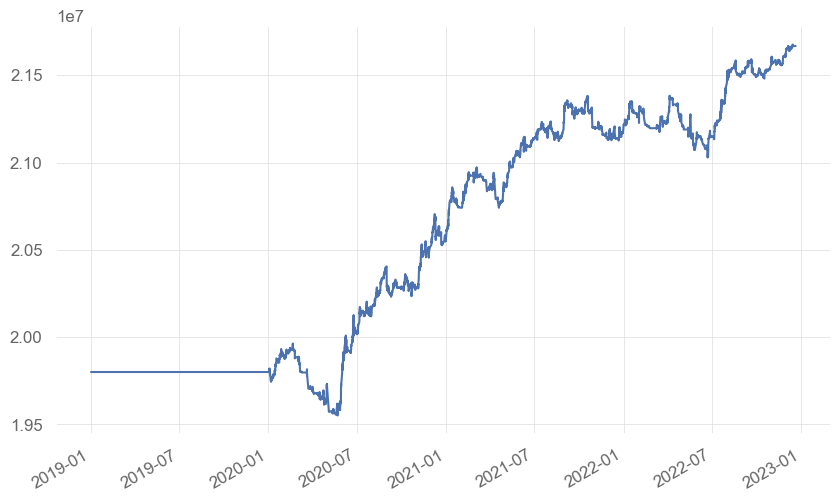

In [142]:
# Filter columns for position and return
position_columns = [col for col in combined_df.columns if 'position' in col]
return_columns = [col for col in combined_df.columns if '_ret' in col]

# Calculate the sum of returns for assets where position is non-zero
combined_df['sum_of_rturns'] = combined_df[return_columns].sum(axis=1)

# Count the number of non-zero positions for each row
combined_df['non_zero_positions'] = combined_df[position_columns].apply(lambda x: (x!=0).sum(), axis=1)

symbol_Equity = (combined_df[return_columns]*100000)

total_profit_from_returns = symbol_Equity.cumsum().iloc[-1]

Portfolio_EC = len(return_columns)*100000+(symbol_Equity.sum(axis=1).cumsum())

Portfolio_EC.plot()


In [20]:
tst =  combined_df.filter(regex='WIPRO')

In [24]:
tst = tst.dropna()

In [26]:
tst.to_csv(r"C:\Users\Administrator\Downloads\testww.csv")


In [ ]:
all_trades